**Table of contents**<a id='toc0_'></a>    
- [Gene Symbol Capture Analysis](#toc1_)    
    - [Combining the annotations from symbol_capture_generation into one table and presenting them in an upset plot](#toc1_1_1_)    
  - [Ortholog Capture Analysis](#toc1_2_)    
    - [Import ortholog_analysis_dfs into notebook](#toc1_2_1_)    
    - [Condense all ortholog_analysis_dfs into one with just a Ortholog column](#toc1_2_2_)    
      - [Put all ortholog_analysis_dfs into a dictionary](#toc1_2_2_1_)    
      - [Import the df that has gene records from NCBI, HGNC, and Ensembl](#toc1_2_2_2_)    
      - [Add the "Species" Match column to the gene record df](#toc1_2_2_3_)    
      - [Using the "Species" Match columns, populate a general "Ortholog" column](#toc1_2_2_4_)    
      - [The df with all of the "Species" Match columns](#toc1_2_2_5_)    
      - [The df with just the "Ortholog" column](#toc1_2_2_6_)    
      - [The df with just the "Ortholog" column and only the True rows](#toc1_2_2_7_)    
    - [How many symbols are otholog symbols?](#toc1_2_3_)    
- [HGNC Previous Symbol Capture Analysis](#toc2_)    
- [FLJ Clone Name Capture Analysis](#toc3_)    
- [Gene Family Symbol Capture Analysis](#toc4_)    
- [Disorder/Disease Symbol Capture Analysis](#toc5_)    
- [Capture Summary](#toc6_)    
    - [Combine the primary gene symbols with the alias symbols to have all gene symbols in one column](#toc6_1_1_)    
    - [Combine the information for the rows with the same primary and alias gene symbols](#toc6_1_2_)    
    - [Create a summary table highliting which symbols have been captured](#toc6_1_3_)    
    - [Data Results](#toc6_1_4_)    
      - [Collisions are treated as unique symbols since they are being characterized in the context of the gene concept they represent](#toc6_1_4_1_)    
      - [The same symbol can represent different relationships for the same gene concept in different sources due to annotation discrepancies](#toc6_1_4_2_)    
      - [% captured shows the amount of gene symbols that are explainable/ have support for why they represent a gene](#toc6_1_4_3_)    
      - [Upset plot: show capture statistics](#toc6_1_4_4_)    
      - [Which gene concepts have different primary gene symbol across the dbs?](#toc6_1_4_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Gene Symbol Capture Analysis](#toc0_)

### <a id='toc1_1_1_'></a>[Combining the annotations from symbol_capture_generation into one table and presenting them in an upset plot](#toc0_)

The block of code that combines all of the tables into one take a long time to run. Might need to look into making it more efficient. 

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from upsetplot import UpSet
from upsetplot import generate_counts, plot
from collections import Counter
import matplotlib.pyplot as plt

## <a id='toc1_2_'></a>[Ortholog Capture Analysis](#toc0_)

### <a id='toc1_2_1_'></a>[Import ortholog_analysis_dfs into notebook](#toc0_)

In [2]:
folder_path = "../output/"  
num_files = 10

file_names = [os.path.join(folder_path, f'ortholog_analysis_{i}_df.csv') for i in range(1, num_files + 1)]

ortholog_analysis_dfs = {}

for i, file_name in enumerate(file_names, start=1):
    df = pd.read_csv(file_name, index_col=0)  

    var_name = f'ortholog_analysis_{i}_df'
    
    globals()[var_name] = df

### <a id='toc1_2_2_'></a>[Condense all ortholog_analysis_dfs into one with just a Ortholog column](#toc0_)

#### <a id='toc1_2_2_1_'></a>[Put all ortholog_analysis_dfs into a dictionary](#toc0_)

In [3]:
ortholog_analysis_dfs_list = [value for key, value in globals().items() 
                if key.startswith('ortholog_analysis') 
                and key.endswith('_df') 
                and isinstance(value, pd.DataFrame)]
ortholog_analysis_dfs_list

[      primary_gene_symbol  alias_symbol    HGNC_ID              ENSG_ID  \
 0              A-GAMMA3'E     A-GAMMA-E      set()                set()   
 1                    A1BG           A1B      {'5'}  {'ENSG00000121410'}   
 2                    A1BG           ABG      {'5'}  {'ENSG00000121410'}   
 3                    A1BG           GAB      {'5'}  {'ENSG00000121410'}   
 4                    A1BG      HYST2477      {'5'}  {'ENSG00000121410'}   
 ...                   ...           ...        ...                  ...   
 87217               ZZEF1      FLJ10821  {'29027'}  {'ENSG00000074755'}   
 87218               ZZEF1      KIAA0399  {'29027'}  {'ENSG00000074755'}   
 87219               ZZEF1          ZZZ4  {'29027'}  {'ENSG00000074755'}   
 87220                ZZZ3         ATAC1  {'24523'}  {'ENSG00000036549'}   
 87221                ZZZ3  DKFZP564I052  {'24523'}  {'ENSG00000036549'}   
 
              NCBI_ID  Abingdon island giant tortoise Match  \
 0      {'109951028'}  

#### <a id='toc1_2_2_2_'></a>[Import the df that has gene records from NCBI, HGNC, and Ensembl](#toc0_)

In [4]:
subset_genes_df = pd.read_hdf(
    "../output/subset_genes_df.h5", key='df'
    )
subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028}
1,A1BG,A1B,{5},{ENSG00000121410},{1}
2,A1BG,ABG,{5},{ENSG00000121410},{1}
3,A1BG,GAB,{5},{ENSG00000121410},{1}
4,A1BG,HYST2477,{5},{ENSG00000121410},{1}
...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140}
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140}
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140}
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009}


In [5]:
subset_genes_df.loc[subset_genes_df["alias_symbol"]=="CTC-537E7.3"]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID


#### <a id='toc1_2_2_3_'></a>[Add the "Species" Match column to the gene record df](#toc0_)

In [6]:
ortholog_analysis_df = subset_genes_df.copy()
for df in ortholog_analysis_dfs_list:
    ortholog_columns = df.iloc[:, 6:]
    ortholog_analysis_df = pd.concat([ortholog_analysis_df, ortholog_columns], axis=1)

ortholog_analysis_df.reset_index(drop=True, inplace=True)

In [7]:
ortholog_analysis_df.head()

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,African ostrich Match,Algerian mouse Match,Alpine marmot Match,Amazon molly Match,American bison Match,...,Chinese hamster CHOK1GS Match,Chimpanzee Match,Clown anemonefish Match,Coelacanth Match,Coho salmon Match,Collared flycatcher Match,Common carp Match,Common wall lizard Match,Common wombat Match,Coquerel's sifaka Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A1BG,A1B,{5},{ENSG00000121410},{1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,A1BG,ABG,{5},{ENSG00000121410},{1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,A1BG,GAB,{5},{ENSG00000121410},{1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### <a id='toc1_2_2_4_'></a>[Using the "Species" Match columns, populate a general "Ortholog" column](#toc0_)

In [8]:
ortholog_analysis_summary_df = ortholog_analysis_df.copy()

In [9]:
info_columns = ortholog_analysis_summary_df.iloc[:, :6]
boolean_columns = ortholog_analysis_summary_df.iloc[:, 6:]

# Create a new column based on whether there's at least one True (T) in the row
ortholog_analysis_summary_df['Ortholog Match'] = boolean_columns.any(axis=1)

# Create a new column with a list of species (derived from the column names) that have True values
ortholog_analysis_summary_df['Matching Species'] = boolean_columns.apply(
    lambda row: [col.replace(' Match', '') for col, match in row.items() if match], axis=1
)

# Concatenate the info columns and the new 'Ortholog Match' and 'Matching Species' columns
ortholog_analysis_summary_df = pd.concat([info_columns, ortholog_analysis_summary_df[['Ortholog Match', 'Matching Species']]], axis=1)

# Display the updated DataFrame
ortholog_analysis_summary_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,African ostrich Match,Ortholog Match,Matching Species
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False,False,[]
1,A1BG,A1B,{5},{ENSG00000121410},{1},False,False,[]
2,A1BG,ABG,{5},{ENSG00000121410},{1},False,False,[]
3,A1BG,GAB,{5},{ENSG00000121410},{1},False,False,[]
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False,False,[]
...,...,...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},False,False,[]
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},False,False,[]
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},False,False,[]
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},False,False,[]


In [10]:
ortholog_analysis_summary_df.head(50)

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,African ostrich Match,Ortholog Match,Matching Species
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False,False,[]
1,A1BG,A1B,{5},{ENSG00000121410},{1},False,False,[]
2,A1BG,ABG,{5},{ENSG00000121410},{1},False,False,[]
3,A1BG,GAB,{5},{ENSG00000121410},{1},False,False,[]
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False,False,[]
5,A1BG-AS1,A1BG-AS,{37133},{ENSG00000268895},{503538},False,False,[]
6,A1BG-AS1,A1BGAS,{37133},{ENSG00000268895},{503538},False,False,[]
7,A1BG-AS1,FLJ23569,{37133},{ENSG00000268895},{503538},False,False,[]
8,A1BG-AS1,NCRNA00181,{37133},{ENSG00000268895},{503538},False,False,[]
9,A1CF,ACF,{24086},{ENSG00000148584},{29974},False,False,[]


#### <a id='toc1_2_2_5_'></a>[The df with all of the "Species" Match columns](#toc0_)

In [11]:
ortholog_analysis_df.to_csv(
    "../output/ortholog_analysis_df.csv", index=True
)

#### <a id='toc1_2_2_6_'></a>[The df with just the "Ortholog" column](#toc0_)

In [12]:
ortholog_analysis_summary_df.to_csv(
    "../output/ortholog_analysis_summary_df.csv", index=True
)

#### <a id='toc1_2_2_7_'></a>[The df with just the "Ortholog" column and only the True rows](#toc0_)

In [13]:
ortholog_analysis_summary_match_df = ortholog_analysis_summary_df[ortholog_analysis_summary_df['Ortholog Match']]

note: ugh. Calmbp1 is the expired mouse name so it doesnt show up

In [14]:
ortholog_analysis_df.loc[
    ortholog_analysis_df["alias_symbol"] == "CALMBP1"
]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,African ostrich Match,Algerian mouse Match,Alpine marmot Match,Amazon molly Match,American bison Match,...,Chinese hamster CHOK1GS Match,Chimpanzee Match,Clown anemonefish Match,Coelacanth Match,Coho salmon Match,Collared flycatcher Match,Common carp Match,Common wall lizard Match,Common wombat Match,Coquerel's sifaka Match
4506,ASPM,CALMBP1,{19048},{ENSG00000066279},{259266},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
ortholog_analysis_summary_df.loc[
    ortholog_analysis_summary_df["alias_symbol"] == "CALMBP1"
]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,African ostrich Match,Ortholog Match,Matching Species
4506,ASPM,CALMBP1,{19048},{ENSG00000066279},{259266},False,False,[]


### <a id='toc1_2_3_'></a>[How many symbols are otholog symbols?](#toc0_)

In [16]:
ortholog_analysis_summary_df.value_counts(subset= "Ortholog Match")

Ortholog Match
False    86341
True       881
Name: count, dtype: int64

# <a id='toc2_'></a>[HGNC Previous Symbol Capture Analysis](#toc0_)

In [17]:
previous_symbol_analysis_df = pd.read_hdf(
    "../output/previous_symbol_analysis_df.h5", key='df'
    )
previous_symbol_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Previous Symbol Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False
1,A1BG,A1B,{5},{ENSG00000121410},{1},False
2,A1BG,ABG,{5},{ENSG00000121410},{1},False
3,A1BG,GAB,{5},{ENSG00000121410},{1},False
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False
...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},False
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},False
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},False
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},False


Just the true rows

In [18]:
previous_symbol_match_subset_genes_df = pd.read_hdf(
    "../output/previous_symbol_match_subset_genes_df.h5", key='df'
    )
previous_symbol_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Previous Symbol Match
5,A1BG-AS1,A1BG-AS,{37133},{ENSG00000268895},{503538},True
6,A1BG-AS1,A1BGAS,{37133},{ENSG00000268895},{503538},True
8,A1BG-AS1,NCRNA00181,{37133},{ENSG00000268895},{503538},True
18,A2ML1,CPAMD9,{23336},{ENSG00000166535},{144568},True
22,A2MP1,A2MP,{8},"{ENSG00000291190, ENSG00000256069}",{124903067},True
...,...,...,...,...,...,...
87187,ZSWIM8,KIAA0913,{23528},{ENSG00000214655},{23053},True
87188,ZSWIM9,C19ORF68,{34495},{ENSG00000185453},{374920},True
87190,ZUP1,C6ORF113,{21224},{ENSG00000153975},{221302},True
87193,ZUP1,ZUFSP,{21224},{ENSG00000153975},{221302},True


# <a id='toc3_'></a>[FLJ Clone Name Capture Analysis](#toc0_)

In [19]:
clone_symbol_analysis_df = pd.read_hdf(
    "../output/clone_symbol_analysis_df.h5", key='df'
    )
clone_symbol_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Clone Symbol Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False
1,A1BG,A1B,{5},{ENSG00000121410},{1},False
2,A1BG,ABG,{5},{ENSG00000121410},{1},False
3,A1BG,GAB,{5},{ENSG00000121410},{1},False
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False
...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},True
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},False
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},False
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},False


In [20]:
clone_symbol_match_subset_genes_df = pd.read_hdf(
    "../output/clone_symbol_match_subset_genes_df.h5", key='df'
    )
clone_symbol_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Clone Symbol Match
7,A1BG-AS1,FLJ23569,{37133},{ENSG00000268895},{503538},True
19,A2ML1,FLJ25179,{23336},{ENSG00000166535},{144568},True
45,AACS,FLJ12389,{21298},{ENSG00000081760},{65985},True
56,AAGAB,FLJ11506,{25662},{ENSG00000103591},{79719},True
65,AAMDC,FLJ21035,{30205},{ENSG00000087884},{28971},True
...,...,...,...,...,...,...
87178,ZSWIM4,FLJ12221,{25704},"{ENSG00000288360, ENSG00000132003}",{65249},True
87196,ZWILCH,FLJ10036,{25468},{ENSG00000174442},{55055},True
87209,ZXDC,FLJ13861,{28160},{ENSG00000070476},{79364},True
87213,ZYG11B,FLJ13456,{25820},{ENSG00000162378},{79699},True


# <a id='toc4_'></a>[Gene Family Symbol Capture Analysis](#toc0_)

In [21]:
gene_group_analysis_df = pd.read_hdf(
    "../output/gene_group_analysis_df.h5", key='df'
    )
gene_group_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Gene Group Symbol Match,Matching Abbreviation
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False,
1,A1BG,A1B,{5},{ENSG00000121410},{1},False,
2,A1BG,ABG,{5},{ENSG00000121410},{1},False,
3,A1BG,GAB,{5},{ENSG00000121410},{1},False,
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False,
...,...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},False,
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},False,
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},True,ZZZ
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},True,ATAC


In [22]:
gene_group_prefix_match_subset_genes_df = pd.read_hdf(
    "../output/gene_group_prefix_match_subset_genes_df.h5", key='df'
    )
gene_group_prefix_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Gene Group Symbol Match,Matching Abbreviation
44,AACS,ACSF1,{21298},{ENSG00000081760},{65985},True,ACS
91,AASDH,ACSF4,{23993},{ENSG00000157426},{132949},True,ACS
115,AATK,PPP1R77,{21},{ENSG00000181409},{9625},True,PPP1R
130,ABCA11P,ABCA11,{31},"{ENSG00000293360, ENSG00000251595}",{79963},True,ABCA
143,ABCA17P,ABCA17,{32972},{ENSG00000293423},{650655},True,ABCA
...,...,...,...,...,...,...,...
87208,ZXDB,ZNF905,{13199},{ENSG00000198455},{158586},True,ZNF
87212,ZYG11A,ZYG11,{32058},{ENSG00000203995},{440590},True,ZYG11
87214,ZYG11B,ZYG11,{25820},{ENSG00000162378},{79699},True,ZYG11
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},True,ZZZ


# <a id='toc5_'></a>[Disorder/Disease Symbol Capture Analysis](#toc0_)

In [23]:
disease_analysis_df = pd.read_hdf(
    "../output/disease_analysis_df.h5", key='df'
    )
disease_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Disease Symbol Match,Matching Phenotype Symbol
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},False,
1,A1BG,A1B,{5},{ENSG00000121410},{1},False,
2,A1BG,ABG,{5},{ENSG00000121410},{1},False,
3,A1BG,GAB,{5},{ENSG00000121410},{1},False,
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},False,
...,...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},False,
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},False,
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},False,
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},False,


In [24]:
disease_prefix_match_subset_genes_df = pd.read_hdf(
    "../output/disease_prefix_match_subset_genes_df.h5", key='df'
    )
disease_prefix_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Disease Symbol Match,Matching Phenotype Symbol
14,A2M,A2MD,{7},{ENSG00000175899},{2},True,A2MD
20,A2ML1,OMS,{23336},{ENSG00000166535},{144568},True,OMS
39,AAAS,AAASB,{13666},{ENSG00000094914},{8086},True,AAAS
59,AAGAB,PPKP1,{25662},{ENSG00000103591},{79719},True,PPKP1
60,AAGAB,PPKP1A,{25662},{ENSG00000103591},{79719},True,PPKP1A
...,...,...,...,...,...,...,...
87101,ZSCAN10,OFNS,{12997},{ENSG00000130182},{84891},True,OFNS
87180,ZSWIM6,AFND,{29316},{ENSG00000130449},{57688},True,AFND
87182,ZSWIM6,NEDMAGA,{29316},{ENSG00000130449},{57688},True,NEDMAGA
87183,ZSWIM7,ODG10,{26993},{ENSG00000214941},{125150},True,ODG10


# <a id='toc6_'></a>[Capture Summary](#toc0_)

In [25]:
primary_gene_symbol_set = set(df["primary_gene_symbol"])

### <a id='toc6_1_1_'></a>[Combine the primary gene symbols with the alias symbols to have all gene symbols in one column](#toc0_)

In [26]:
df = subset_genes_df.copy()
df_primary = df[['primary_gene_symbol', 'HGNC_ID', 'ENSG_ID', 'NCBI_ID']].copy()
df_primary['gene_symbols'] = df_primary['primary_gene_symbol']
df_primary

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,{},{},{109951028},A-GAMMA3'E
1,A1BG,{5},{ENSG00000121410},{1},A1BG
2,A1BG,{5},{ENSG00000121410},{1},A1BG
3,A1BG,{5},{ENSG00000121410},{1},A1BG
4,A1BG,{5},{ENSG00000121410},{1},A1BG
...,...,...,...,...,...
87217,ZZEF1,{29027},{ENSG00000074755},{23140},ZZEF1
87218,ZZEF1,{29027},{ENSG00000074755},{23140},ZZEF1
87219,ZZEF1,{29027},{ENSG00000074755},{23140},ZZEF1
87220,ZZZ3,{24523},{ENSG00000036549},{26009},ZZZ3


In [27]:
df_aliases = df[['primary_gene_symbol', 'alias_symbol', 'HGNC_ID', 'ENSG_ID', 'NCBI_ID']].copy()
df_aliases['gene_symbols'] = df_aliases['alias_symbol']
df_aliases

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,A-GAMMA-E,{},{},{109951028},A-GAMMA-E
1,A1BG,A1B,{5},{ENSG00000121410},{1},A1B
2,A1BG,ABG,{5},{ENSG00000121410},{1},ABG
3,A1BG,GAB,{5},{ENSG00000121410},{1},GAB
4,A1BG,HYST2477,{5},{ENSG00000121410},{1},HYST2477
...,...,...,...,...,...,...
87217,ZZEF1,FLJ10821,{29027},{ENSG00000074755},{23140},FLJ10821
87218,ZZEF1,KIAA0399,{29027},{ENSG00000074755},{23140},KIAA0399
87219,ZZEF1,ZZZ4,{29027},{ENSG00000074755},{23140},ZZZ4
87220,ZZZ3,ATAC1,{24523},{ENSG00000036549},{26009},ATAC1


In [28]:
df_combined = pd.concat([df_primary, df_aliases], ignore_index=True)
df_combined.drop(["alias_symbol"], axis=1, inplace=True)
df_combined

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,{},{},{109951028},A-GAMMA3'E
1,A1BG,{5},{ENSG00000121410},{1},A1BG
2,A1BG,{5},{ENSG00000121410},{1},A1BG
3,A1BG,{5},{ENSG00000121410},{1},A1BG
4,A1BG,{5},{ENSG00000121410},{1},A1BG
...,...,...,...,...,...
174439,ZZEF1,{29027},{ENSG00000074755},{23140},FLJ10821
174440,ZZEF1,{29027},{ENSG00000074755},{23140},KIAA0399
174441,ZZEF1,{29027},{ENSG00000074755},{23140},ZZZ4
174442,ZZZ3,{24523},{ENSG00000036549},{26009},ATAC1


In [29]:
df_combined.loc[df_combined["primary_gene_symbol"]== "A1BG"]

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
1,A1BG,{5},{ENSG00000121410},{1},A1BG
2,A1BG,{5},{ENSG00000121410},{1},A1BG
3,A1BG,{5},{ENSG00000121410},{1},A1BG
4,A1BG,{5},{ENSG00000121410},{1},A1BG
87223,A1BG,{5},{ENSG00000121410},{1},A1B
87224,A1BG,{5},{ENSG00000121410},{1},ABG
87225,A1BG,{5},{ENSG00000121410},{1},GAB
87226,A1BG,{5},{ENSG00000121410},{1},HYST2477


In [30]:
df_combined.loc[df_combined["gene_symbols"]== "A1B"]

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
87223,A1BG,{5},{ENSG00000121410},{1},A1B
159238,SNTB1,{11168},{ENSG00000172164},{6641},A1B


### <a id='toc6_1_2_'></a>[Combine the information for the rows with the same primary and alias gene symbols](#toc0_)

In [31]:
def merge_sets(group):
    """ Merge information for groups of rows

    :param group: rows with the same values for selected columns
    return: a df of gene records
    """
        
    merged_HGNC = set()
    merged_ENSG = set()
    merged_NCBI = set()
    merged_sources = set()

    # iterate over the group to merge information, unions to combine sets
    for _, row in group.iterrows():
        merged_HGNC |= row['HGNC_ID']  
        merged_ENSG |= row['ENSG_ID']
        merged_NCBI |= row['NCBI_ID'] 

    # return a new row with the merged information
    return pd.Series({
        'HGNC_ID': merged_HGNC,
        'ENSG_ID': merged_ENSG,
        'NCBI_ID': merged_NCBI,
        'primary_gene_symbol': group['primary_gene_symbol'].iloc[0],  # all rows in the group should have the same value for primary gene symbol and alias
        'gene_symbols': group['gene_symbols'].iloc[0]  
    })


In [32]:
df_combined = df_combined.groupby(['primary_gene_symbol', 'gene_symbols']).apply(merge_sets).reset_index(drop=True)
df_combined

/var/folders/vt/znzp_c6s02q6kjcmqfk0cb500000gq/T/ipykernel_44252/1261017275.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = df_combined.groupby(['primary_gene_symbol', 'gene_symbols']).apply(merge_sets).reset_index(drop=True)


,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols
0,{},{},{109951028},A-GAMMA3'E,A-GAMMA-E
1,{},{},{109951028},A-GAMMA3'E,A-GAMMA3'E
2,{5},{ENSG00000121410},{1},A1BG,A1B
3,{5},{ENSG00000121410},{1},A1BG,A1BG
4,{5},{ENSG00000121410},{1},A1BG,ABG
...,...,...,...,...,...
117450,{29027},{ENSG00000074755},{23140},ZZEF1,ZZEF1
117451,{29027},{ENSG00000074755},{23140},ZZEF1,ZZZ4
117452,{24523},{ENSG00000036549},{26009},ZZZ3,ATAC1
117453,{24523},{ENSG00000036549},{26009},ZZZ3,DKFZP564I052


### <a id='toc6_1_3_'></a>[Create a summary table highliting which symbols have been captured](#toc0_)

If this section is commented out, it is because I wanted to stop myself from rerunning it. It takes a long time to run and downstream code depends on it. 

In [33]:
# summary_df = df_combined.copy()

In [34]:
# relationship_dfs = [
#     {"df": previous_symbol_match_subset_genes_df, "type": "HGNC Previous Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": ortholog_analysis_summary_match_df, "type": "Ortholog", "check": 
#           lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": clone_symbol_match_subset_genes_df, "type": "Clone Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": gene_group_prefix_match_subset_genes_df, "type": "Prefix Gene Group Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": disease_prefix_match_subset_genes_df, "type": "Prefix Disease Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},      
#     {"df": None, "type": "Primary Gene Symbol", "check": lambda row, df: row['gene_symbols'] == row['primary_gene_symbol'] and row['gene_symbols'] in primary_gene_symbol_set}
# ]
# # Add the 'classified' column to df_main
# def capture_row(row):
#     classifications = []
#     for relationship_df in relationship_dfs:
#         if relationship_df["check"](row, relationship_df["df"]):
#             classifications.append(relationship_df["type"])
#     return classifications

# tqdm.pandas()

# summary_df['relationships'] = summary_df.progress_apply(capture_row, axis=1)
# summary_df['captured'] = summary_df['relationships'].apply(lambda x: 'T' if x else 'F')
# summary_df['captured as:'] = summary_df['relationships'].apply(lambda x: ', '.join(x) if x else None)

# # Drop the intermediate classifications list if not needed
# summary_df.drop(columns=["relationships"], inplace=True)

# summary_df


In [35]:
# summary_df.to_csv(
#     "../output/summary_df.csv", index=True
# )

In [36]:
# summary_df.to_hdf(
#     "../output/summary_df.h5", key='df', mode='w'
# )

In [37]:
capture_df = pd.read_hdf(
    "../output/summary_df.h5", key='df'
    )
capture_df

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
0,{},{},{109951028},A-GAMMA3'E,A-GAMMA-E,F,None
1,{},{},{109951028},A-GAMMA3'E,A-GAMMA3'E,T,Primary Gene Symbol
2,{5},{ENSG00000121410},{1},A1BG,A1B,F,None
3,{5},{ENSG00000121410},{1},A1BG,A1BG,T,Primary Gene Symbol
4,{5},{ENSG00000121410},{1},A1BG,ABG,F,None
...,...,...,...,...,...,...,...
116647,{29027},{ENSG00000074755},{23140},ZZEF1,ZZEF1,T,Primary Gene Symbol
116648,{29027},{ENSG00000074755},{23140},ZZEF1,ZZZ4,T,Prefix Gene Group Symbol
116649,{24523},{ENSG00000036549},{26009},ZZZ3,ATAC1,T,Prefix Gene Group Symbol
116650,{24523},{ENSG00000036549},{26009},ZZZ3,DKFZP564I052,F,None


In [38]:
capture_df.head(50)

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
0,{},{},{109951028},A-GAMMA3'E,A-GAMMA-E,F,None
1,{},{},{109951028},A-GAMMA3'E,A-GAMMA3'E,T,Primary Gene Symbol
2,{5},{ENSG00000121410},{1},A1BG,A1B,F,None
3,{5},{ENSG00000121410},{1},A1BG,A1BG,T,Primary Gene Symbol
4,{5},{ENSG00000121410},{1},A1BG,ABG,F,None
5,{5},{ENSG00000121410},{1},A1BG,GAB,F,None
6,{5},{ENSG00000121410},{1},A1BG,HYST2477,F,None
7,{37133},{ENSG00000268895},{503538},A1BG-AS1,A1BG-AS,T,HGNC Previous Symbol
8,{37133},{ENSG00000268895},{503538},A1BG-AS1,A1BG-AS1,T,Primary Gene Symbol
9,{37133},{ENSG00000268895},{503538},A1BG-AS1,A1BGAS,T,HGNC Previous Symbol


In [39]:
capture_df.loc[capture_df["captured as:"] == "HGNC Previous Symbol, Clone Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
59460,{1274},{ENSG00000215386},{388815},MIR99AHG,FLJ38295,T,"HGNC Previous Symbol, Clone Symbol"


### <a id='toc6_1_4_'></a>[Data Results](#toc0_)

#### <a id='toc6_1_4_1_'></a>[Collisions are treated as unique symbols since they are being characterized in the context of the gene concept they represent](#toc0_)

In [40]:
capture_df.loc[capture_df["gene_symbols"]=="TR2"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
21361,{29899},{ENSG00000121690},{91614},DEPDC7,TR2,F,None
66054,{7971},{ENSG00000120798},{7181},NR2C1,TR2,T,HGNC Previous Symbol
100446,{14905},{ENSG00000179002},{80834},TAS1R2,TR2,F,None
104036,{11912},"{ENSG00000273936, ENSG00000157873}",{8764},TNFRSF14,TR2,F,None
109838,{20667},{ENSG00000197763},{114112},TXNRD3,TR2,F,None


#### <a id='toc6_1_4_2_'></a>[The same symbol can represent different relationships for the same gene concept in different sources due to annotation discrepancies](#toc0_)

In [41]:
capture_df.loc[capture_df["gene_symbols"]=="ABHD11-AS1"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
449,{18289},{},{171022},ABHD11-AS1,ABHD11-AS1,T,Primary Gene Symbol
8055,{18289},{ENSG00000225969},{},BICDL3P,ABHD11-AS1,T,HGNC Previous Symbol


#### <a id='toc6_1_4_3_'></a>[% captured shows the amount of gene symbols that are explainable/ have support for why they represent a gene](#toc0_)

In [42]:
capture_df["captured"].value_counts()

captured
T    62629
F    54023
Name: count, dtype: int64

In [43]:
capture_df.loc[capture_df["captured as:"]=="HGNC Previous Symbol, Prefix Gene Group Symbol, Prefix Disease Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
8646,{1101},{ENSG00000139618},{675},BRCA2,FANCD1,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
26243,{3434},{ENSG00000104884},{2068},ERCC2,XPD,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
26257,{3436},{ENSG00000175595},{2072},ERCC4,XPF,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
26264,{3437},{ENSG00000134899},{2073},ERCC5,XPGC,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
28294,{3582},{ENSG00000187741},{2175},FANCA,FANCH,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."


In [44]:
capture_df.loc[capture_df["gene_symbols"]=="FLJ10517"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
5835,{19048},{ENSG00000066279},{259266},ASPM,FLJ10517,T,Clone Symbol


#### <a id='toc6_1_4_4_'></a>[Upset plot: show capture statistics](#toc0_)

make a list of the possible categories for capture

In [45]:
category_list = ['HGNC Previous Symbol', 'Prefix Gene Group Symbol', 'Primary Gene Symbol', 'Clone Symbol', "Ortholog", "Prefix Disease Symbol"]

create a column with a set of categories that the symbol has been captured as

In [46]:
upsetplot_capture_df = capture_df.copy()
upsetplot_capture_df['category_sets'] = upsetplot_capture_df['captured as:'].apply(lambda x: set(str(x).split(', ')) if isinstance(x, str) else set())

creates a binary matrix with the different categories

In [47]:
for category in category_list:
    upsetplot_capture_df[category] = upsetplot_capture_df['category_sets'].apply(lambda x: category in x).astype(int)

how often each combination of categories captured appears

In [48]:
combination_counts = upsetplot_capture_df[category_list].agg(tuple, axis=1).value_counts()

converting the index of combination_counts from tuples to a hierarchical MultiIndex

In [49]:
combination_counts.index = pd.MultiIndex.from_tuples(combination_counts.index)

In [50]:
new_index = []

for level in combination_counts.index:
    # replace NaN/None values in each level of the MultiIndex tuple
    new_index.append(tuple(x if x is not None and pd.notna(x) else -1 for x in level))

combination_counts.index = pd.MultiIndex.from_tuples(new_index, names=combination_counts.index.names)

set the names of the levels in the MultiIndex of combination_counts to match the categories in category_list

In [51]:
combination_counts.index.names = category_list
combination_counts.index.names

FrozenList(['HGNC Previous Symbol', 'Prefix Gene Group Symbol', 'Primary Gene Symbol', 'Clone Symbol', 'Ortholog', 'Prefix Disease Symbol'])

/Users/rsaxs014/Desktop/gene-harmony-analysis/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/rsaxs014/Desktop/gene-harmony-analysis/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

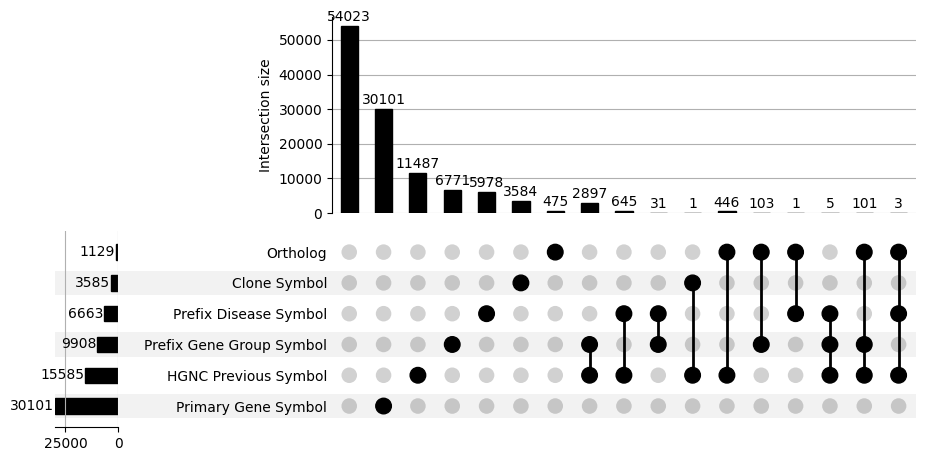

In [52]:
upset = UpSet(combination_counts, show_counts=True)
upset.plot()

#### <a id='toc6_1_4_5_'></a>[Which gene concepts have different primary gene symbol across the dbs?](#toc0_)

In [53]:
primary_symbols_analysis_capture_df = capture_df.copy()
# Step 1: Convert sets in 'Column 1' to frozensets for grouping
primary_symbols_analysis_capture_df['HGNC_ID'] = primary_symbols_analysis_capture_df['HGNC_ID'].apply(frozenset)

# Step 2: Remove rows with empty sets
primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df[primary_symbols_analysis_capture_df['HGNC_ID'].apply(lambda x: bool(x))]  # Exclude empty frozensets

# Step 2: Identify the sets where there are multiple distinct values in 'Column 3'
# Group by 'Column 1' and check for multiple unique values in 'Column 3'
grouped_primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df.groupby('HGNC_ID')['primary_gene_symbol'].nunique()

# Step 3: Filter for groups where there are more than 1 unique value in 'Column 3'
filter_sets = grouped_primary_symbols_analysis_capture_df[grouped_primary_symbols_analysis_capture_df > 1].index

# Step 4: Filter the original DataFrame for rows where 'Column 1' is in those sets
filtered_primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df[primary_symbols_analysis_capture_df['HGNC_ID'].isin(filter_sets)]

# Display the result
filtered_primary_symbols_analysis_capture_df


,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
185,(34405),{ENSG00000189149},{400508},ABCA15P,ABCA15P,T,Primary Gene Symbol
186,(34405),{ENSG00000189149},{},ABCA15P,CRYM-AS1,T,HGNC Previous Symbol
187,(34405),{ENSG00000189149},{400508},ABCA15P,FLJ41766,T,Clone Symbol
188,(34405),{ENSG00000189149},{},ABCA15P,NCRNA00169,T,HGNC Previous Symbol
449,(18289),{},{171022},ABHD11-AS1,ABHD11-AS1,T,Primary Gene Symbol
...,...,...,...,...,...,...,...
116083,(13142),{ENSG00000184624},{},ZNF72BP,ZNF72P,T,HGNC Previous Symbol
116084,(13142),{},{100287084},ZNF72P,COS8,F,None
116085,(13142),{},{100287084},ZNF72P,ZNF1,F,None
116086,(13142),{},{100287084},ZNF72P,ZNF72,F,None


In [54]:
filtered_primary_symbols_analysis_capture_df = filtered_primary_symbols_analysis_capture_df.drop_duplicates(subset='primary_gene_symbol')
filtered_primary_symbols_analysis_capture_df = filtered_primary_symbols_analysis_capture_df.sort_values(by='HGNC_ID', ascending=True)
filtered_primary_symbols_analysis_capture_df

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
185,(34405),{ENSG00000189149},{400508},ABCA15P,ABCA15P,T,Primary Gene Symbol
80394,(16506),{ENSG00000283945},{},REXO6P,C9ORF14,T,HGNC Previous Symbol
76818,(17346),{ENSG00000112739},{8899},PRPF4B,KIAA0536,F,None
76753,(17346),{ENSG00000112739},{8899},PRP4K,DJ1013A10.1,F,None
63670,(7462),{},{4541},ND6,MTND6,F,None
...,...,...,...,...,...,...,...
48093,(28325),{ENSG00000258701},{196872},LINC00638,LINC00638,T,Primary Gene Symbol
47553,(16506),{ENSG00000291187},{158035},LINC00032,C9ORF14,F,None
44525,(16631),{ENSG00000134056},{92259},KGD4,DC47,F,None
61447,(7422),{ENSG00000198938},{4514},MT-CO3,CO3,F,None


here is where i stopped because idk if i need to do this with all ids? and how do i cross ref them?

In [55]:
capture_df.loc[capture_df["captured as:"]=="Prefix Gene Group Symbol, Primary Gene Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:


In [56]:
capture_df.loc[capture_df["primary_gene_symbol"]=="ABHD11"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
446,{16407},{ENSG00000106077},{83451},ABHD11,ABHD11,T,Primary Gene Symbol
447,{16407},{ENSG00000106077},{83451},ABHD11,PP1226,F,None
448,{16407},{ENSG00000106077},{83451},ABHD11,WBSCR21,T,HGNC Previous Symbol
